## 02_Exploratory Data Analysis

In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

BASE = '..'
INPUT = os.path.join(BASE, 'data', 'Nova_pay_cleaned_dataset.csv')

df = pd.read_csv(INPUT, parse_dates=['timestamp'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11140 entries, 0 to 11139
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   transaction_id             11140 non-null  object             
 1   customer_id                11140 non-null  object             
 2   timestamp                  11140 non-null  datetime64[ns, UTC]
 3   home_country               11140 non-null  object             
 4   source_currency            11140 non-null  object             
 5   dest_currency              11140 non-null  object             
 6   channel                    11140 non-null  object             
 7   amount_src                 11140 non-null  float64            
 8   amount_usd                 11140 non-null  float64            
 9   fee                        11140 non-null  float64            
 10  exchange_rate_src_to_dest  11140 non-null  float64            
 11  de

In [14]:
# Feature Enginering - Create columns for time of the day, day of week, hour_group, risk_score_bin

df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()


def map_hour_group(h):
    if 0 <= h < 4:
        return "Late Night"
    elif 4 <= h < 8:
       return "Early Morning"
    elif 8 <= h < 18:
       return "Work Hours"
    else:
       return "Evening"

df['hour_group'] = df['hour'].apply(map_hour_group)


# Create bins for the risk score
df["risk_bin"] = pd.cut(df["risk_score_internal"], bins=[0,0.2,0.4,0.6,0.8,1.0])

# save engineered columns
feat_out = os.path.join(BASE, 'data', 'Nova_pay_features.csv')
df.to_csv(feat_out, index=False)
print(df.shape)
print('Saved features to', feat_out)

(11140, 32)
Saved features to ..\data\Nova_pay_features.csv


### Discriptive statistic

In [17]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
amount_src,11140.0,441.272029,1365.755472,7.230,92.6675,160.825000,295.430000,11942.890000
amount_usd,11140.0,443.487897,1380.522475,7.230,94.3400,163.645000,296.635000,12498.570000
fee,11140.0,97.246917,942.736611,0.500,2.4500,3.530000,5.470000,9999.990000
exchange_rate_src_to_dest,11140.0,167.718744,382.222548,0.592,1.0000,7.142857,73.529412,1388.888889
ip_risk_score,11140.0,0.394207,0.262114,0.004,0.2090,0.325000,0.488000,1.000000
account_age_days,11140.0,392.892190,342.075604,1.000,147.0000,292.000000,661.000000,1095.000000
device_trust_score,11140.0,0.654929,0.265034,0.000,0.5150,0.654500,0.894000,0.999000
chargeback_history_count,11140.0,0.049551,0.258902,0.000,0.0000,0.000000,0.000000,2.000000
risk_score_internal,11140.0,0.267740,0.143684,0.000,0.1690,0.223000,0.391000,0.900000
txn_velocity_1h,11140.0,0.482585,1.522422,0.000,0.0000,0.000000,0.000000,8.000000


### Handling Outliers

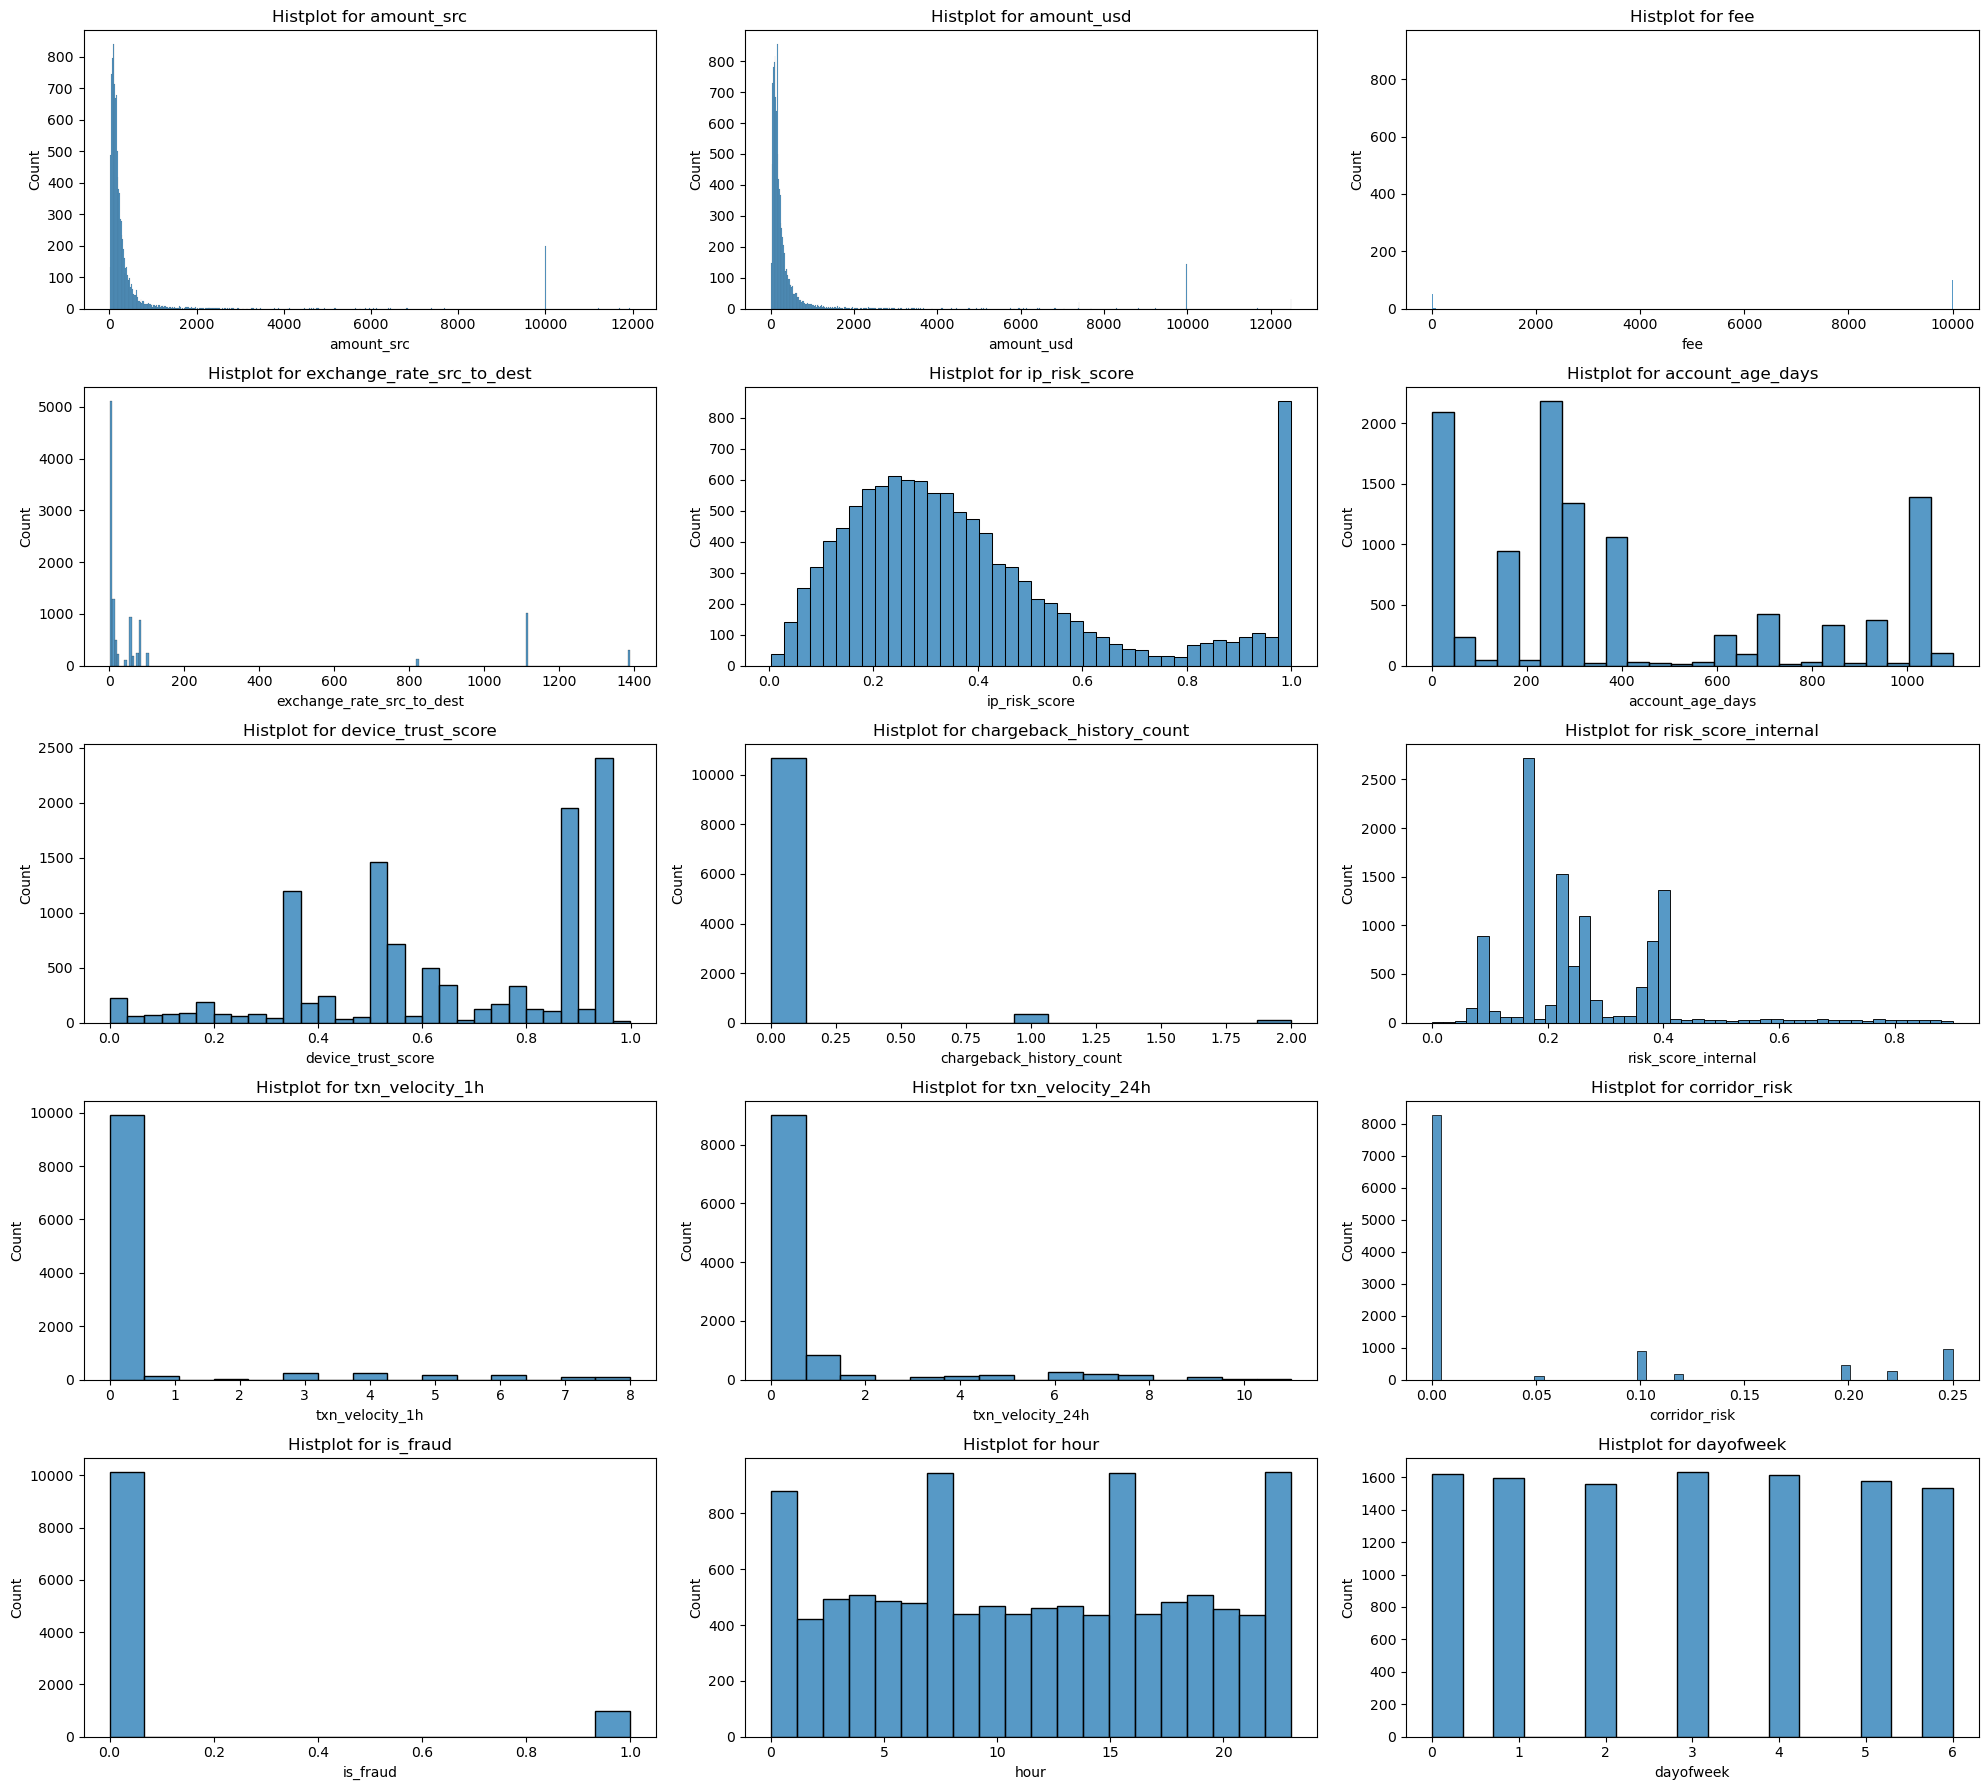

In [24]:
# Visualize the distribution of numerical columns
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,18))
ax = ax.flatten()

num_columns = df.select_dtypes(include="number").columns
for idx, col in enumerate(num_columns):
    sns.histplot(df [col], ax =ax[idx])
    ax[idx].set_title(f"Histplot for {col}")

plt.tight_layout()
plt.show()

### Visualization

Text(0.5, 1.0, 'Fraud Rate (%) by Transaction Velocity (24hr)')

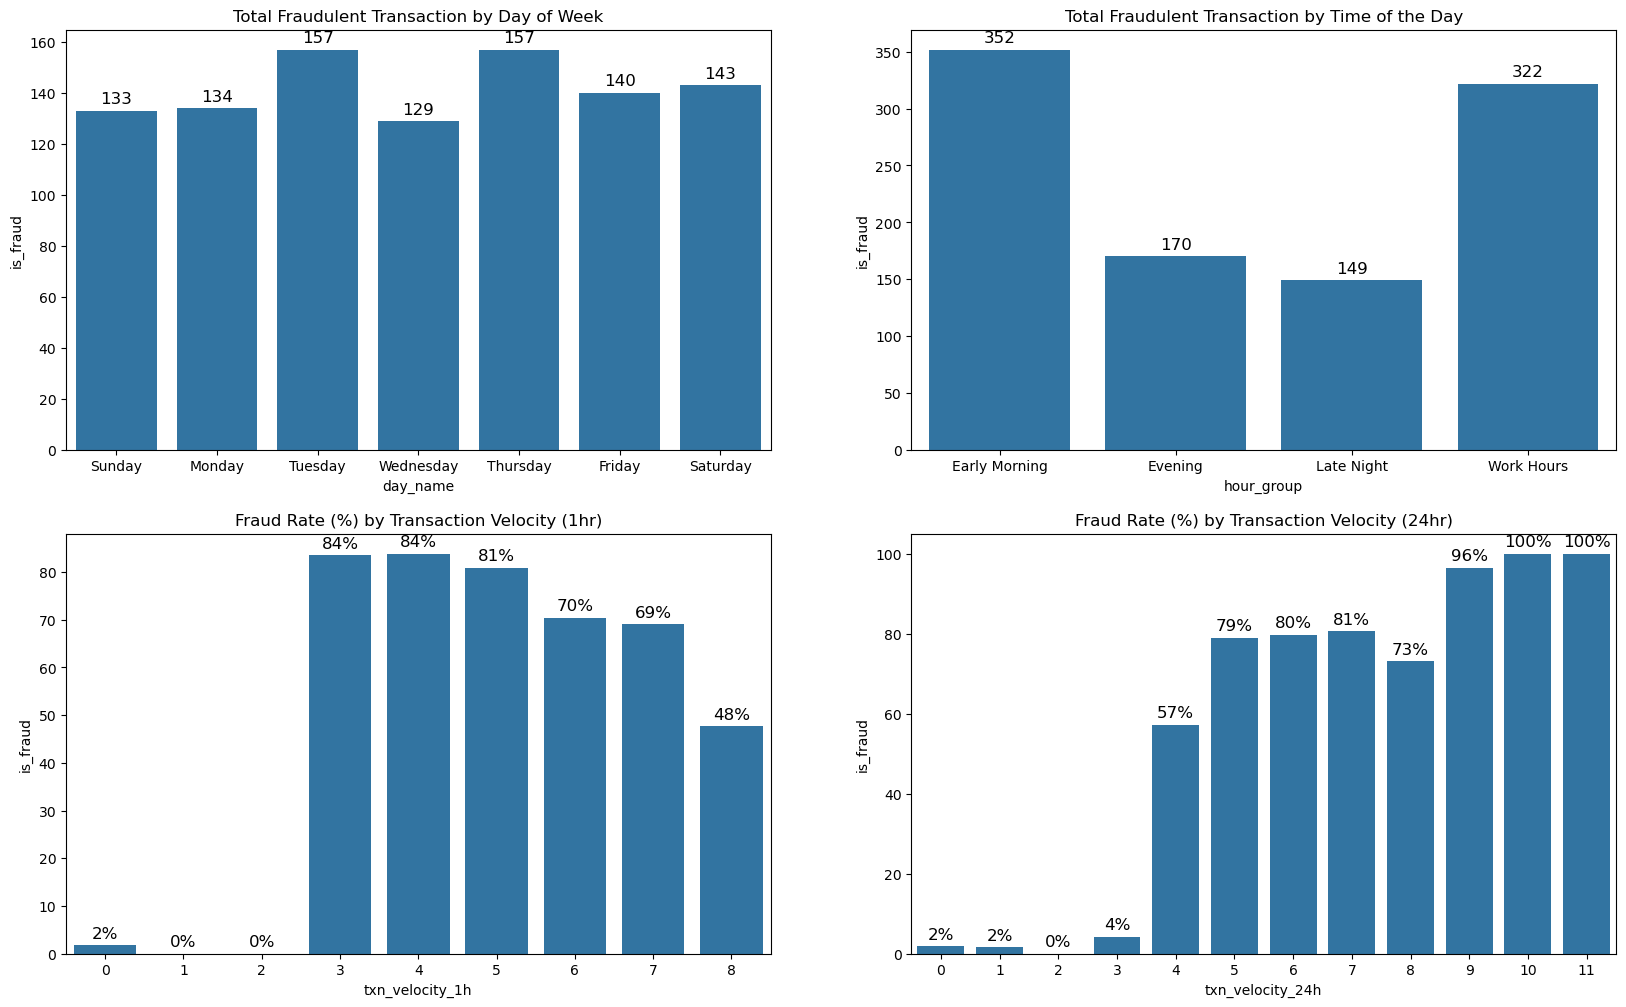

In [27]:
# is_fraud by time and transaction velocity

fig, axs =plt.subplots(nrows=2, ncols=2, figsize=(20,12))

fraud_by_day = df.groupby("day_name")["is_fraud"].sum().reset_index()
day_order = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
fraud_by_day["day_name"] = pd.Categorical(fraud_by_day["day_name"], categories=day_order, ordered=True)
fraud_by_day = fraud_by_day.sort_values("day_name")
sns.barplot(x="day_name", data=fraud_by_day, y="is_fraud", ax=axs[0,0])
for container in axs[0,0].containers:
    axs[0,0].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0,0].set_title("Total Fraudulent Transaction by Day of Week")

fraud_by_hour = df.groupby("hour_group")["is_fraud"].sum().reset_index()
sns.barplot(x="hour_group", data=fraud_by_hour, y="is_fraud", ax=axs[0,1])
for container in axs[0,1].containers:
    axs[0,1].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0,1].set_title("Total Fraudulent Transaction by Time of the Day")

fraud_rate = (df.groupby("txn_velocity_1h")["is_fraud"].mean()*100).reset_index()
sns.barplot(x="txn_velocity_1h", data=fraud_rate, y="is_fraud", ax=axs[1,0])
for container in axs[1,0].containers:
    axs[1,0].bar_label(container, fmt='%.0f%%', padding=3, fontsize=12)
axs[1,0].set_title("Fraud Rate (%) by Transaction Velocity (1hr)")

fraud_rate2 = (df.groupby("txn_velocity_24h")["is_fraud"].mean()*100).reset_index()
sns.barplot(x="txn_velocity_24h", data=fraud_rate2, y="is_fraud", ax=axs[1,1])
for container in axs[1,1].containers:
    axs[1,1].bar_label(container, fmt='%.0f%%', padding=3, fontsize=12)
axs[1,1].set_title("Fraud Rate (%) by Transaction Velocity (24hr)")

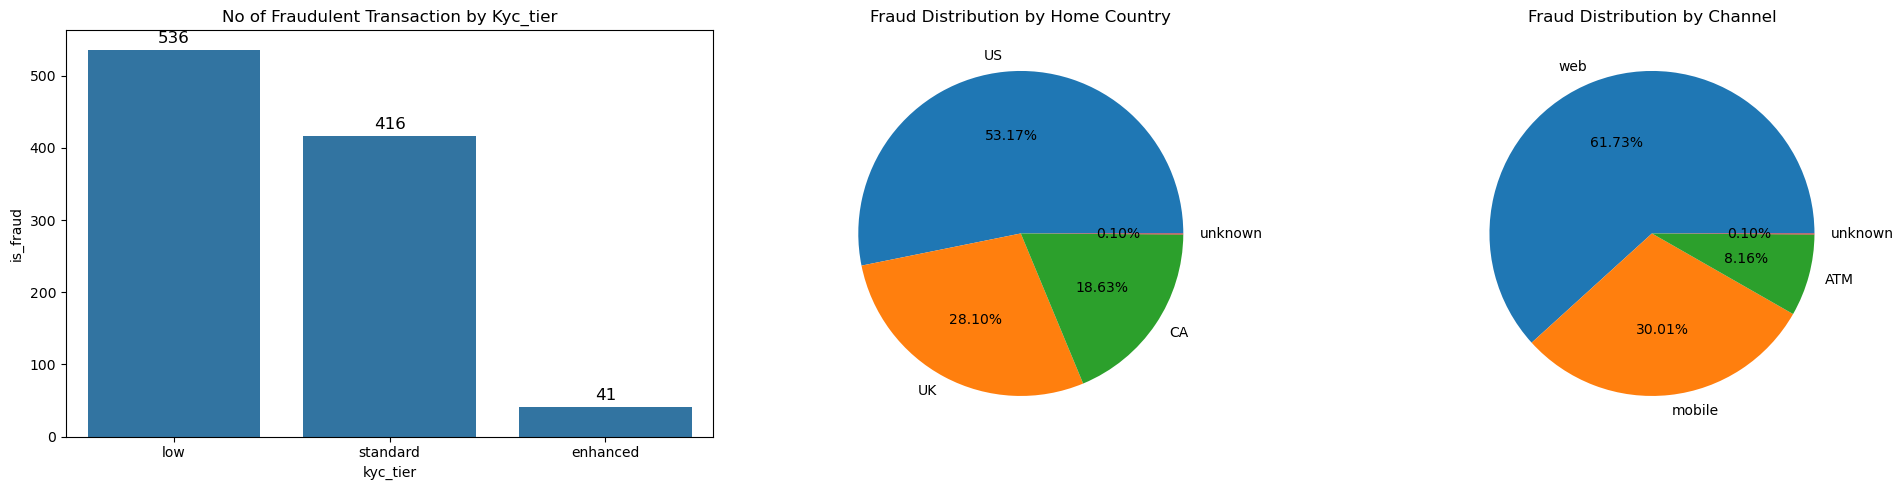

In [29]:
fig, axs =plt.subplots(nrows=1, ncols=3, figsize=(20,5))

fraud_by_kyc_tier = df.groupby("kyc_tier")["is_fraud"].sum().reset_index().sort_values("is_fraud", ascending=False)
sns.barplot(x="kyc_tier", data=fraud_by_kyc_tier, y="is_fraud", ax=axs[0])
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0].set_title("No of Fraudulent Transaction by Kyc_tier")

fraud_by_country = df.groupby("home_country")["is_fraud"].sum().sort_values(ascending=False)
axs[1].pie(fraud_by_country.values, labels=fraud_by_country.index, autopct=lambda p:f'{p:.2f}%')
axs[1].set_title("Fraud Distribution by Home Country")

fraud_by_channel = df.groupby("channel")["is_fraud"].sum().sort_values(ascending=False)
axs[2].pie(fraud_by_channel.values, labels=fraud_by_channel.index, autopct=lambda p:f'{p:.2f}%')
axs[2].set_title("Fraud Distribution by Channel")

plt.tight_layout()
plt.show();


Text(0.5, 1.0, 'Fraud Rate (%) by Risk Score')

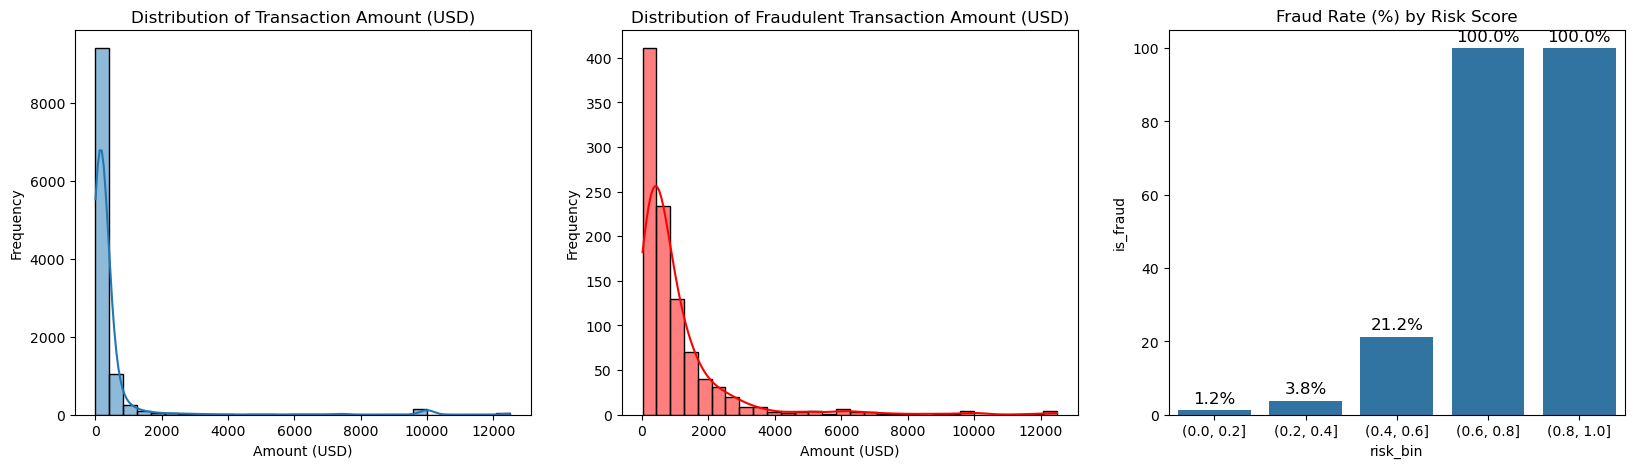

In [31]:
fig, axs =plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sns.histplot(df["amount_usd"], bins=30, kde=True, ax=axs[0])
axs[0].set_title("Distribution of Transaction Amount (USD)")
axs[0].set_xlabel("Amount (USD)")
axs[0].set_ylabel("Frequency")

sns.histplot(df[df["is_fraud"] == 1]["amount_usd"], bins=30, kde=True, color='red', ax=axs[1])
axs[1].set_title("Distribution of Fraudulent Transaction Amount (USD)")
axs[1].set_xlabel("Amount (USD)")
axs[1].set_ylabel("Frequency")

risk_bin_rate = (df.groupby("risk_bin", observed=False)["is_fraud"].mean() * 100).reset_index()
sns.barplot(data=risk_bin_rate, x="risk_bin", y="is_fraud", ax=axs[2])
for container in axs[2].containers:
    axs[2].bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)
axs[2].set_title("Fraud Rate (%) by Risk Score")